In [1]:
## Importing basic packages
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import time
import copy
import random
import os, glob, shutil
from pathlib import Path

from dataclasses import dataclass
from multiprocessing import Pool
import subprocess
import warnings

## For sigma masking
from astropy.stats import sigma_clip, sigma_clipped_stats

## Image
import skimage

## Importing DH packages
import DH_array as dharray
import DH_path as dhpath
import DH_LegacyCrawling as dhcrawl
import DH_Galfit as dhgalfit
import DH_masking as dhmask
import DH_masking2 as dhmask2
import DH_FileCheck as dhfc
import DH_Galfit_Sequence as dhgalseq

## Importing drawing packages
from matplotlib import gridspec
from matplotlib.ticker import AutoMinorLocator
from skimage.transform import resize

## Importing astropy packages
from astropy.modeling.functional_models import Sersic1D, Sersic2D
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.utils.data import download_file
from astropy.wcs import WCS
from astropy.visualization import ZScaleInterval,ImageNormalize,AsinhStretch

This machine : SO desktop computer
LegacyCrawling - Loading summary fits south :  /home/donghyeon/ua/udg/galfit/galfit/RawData/survey-bricks-dr9-south.fits
LegacyCrawling - Loading summary fits south (DR10) :  /home/donghyeon/ua/udg/galfit/galfit/RawData/survey-bricks-dr10-south.fits
LegacyCrawling - Loading summary fits north :  /home/donghyeon/ua/udg/galfit/galfit/RawData/survey-bricks-dr9-north.fits


In [2]:
## Set to Galfit Result directory (You can make a new one)
os.chdir('./Galfit_Run/Brandon')

# Setting

Here, we will make folders and setup the coordinates

* Ncore: For multi-core processing. Number of cores.
* DI: It will manage the result file. 
  * dir_work_base: the result file will be saved here
* DIimg: It stores image files.

In [3]:
## For multi-core processing - Number of cores
Ncore=16

## parameters
plate_scale=0.2 #arcsec / pix
image_size=200 ## pixel

## Coordinates
fn="./../../../coordinates/targetlist2.csv" ## CSV, list file that has RA, Dec, name ...
target=np.loadtxt(fn, skiprows=1, delimiter=',', dtype=object)

coord_array=target[:,0:2].astype(float) ## RA, Dec
name_array=target[:,2] ## Name

## Result will saved here
DI=dhfc.DirInfo('./', dir_work_base='gal_out/', ## Galfit results will be saved here
                group_rule='', use_group=False, 
                folder_rule="gal%04d/",  ## Namimg rule. 04d -> 4 digit -> up to 10000. You can change this value
                coord_array=coord_array, 
                idlist=np.arange(len(coord_array)),  ## We do not need to change it
                catalogname_list=name_array,  ## If you have catalog name, put here
               )

## Image file only
DIimg=DI.change_work_base('gal_img/', return_new=True)
print(len(DIimg.dir_work_list))

10


In [4]:
target

array([['71.6578313', '-10.2263602', 'ZTF19abzrhgq'],
       ['123.3206388', '22.648318', ' ZTF17aaazdba'],
       ['136.3578499', '61.8025699', 'ZTF20acitpfz'],
       ['232.6575481', '26.9824432', 'ZTF20achpcvt'],
       ['314.2623552', '14.2044787', ' ZTF19aapreis'],
       ['230.3336852', '14.0696032', 'ZTF20abgwfek'],
       ['232.8956925', '33.0948917', ' ZTF20aabqihu '],
       ['189.7348778', '33.1658869', 'ZTF19acspeuw'],
       ['105.8276892', '23.0290953', ' ZTF19aabbnzo '],
       ['176.6514953', '30.0854257', 'ZTF21aaaokyp']], dtype=object)

In [5]:
## Make directory
DI.make_dir_work()
DIimg.make_dir_work()

# Download

## PSF

As the first step, we will download psf model files from the LegacySurvey database.
We will save the data in 'DIimg'

In [6]:
## First round - short timeout
results=dhcrawl.multicore_download_cutout(DIimg, show_progress=2000, Ncore=16, overwrite=False, 
                                  Ntry=1, timeout=5, silent_error=True, show_summary=True)
FG=dhfc.FileGroupSearch(DirInfo=DIimg, fn_set=['psf_model_dr9_s.fits', 
                                            'psf_model_dr9_n.fits', 
                                            'psf_model_dr10_s.fits'])

Start Multicore run
======== Multicore Briefing ========
● Multicore run for sub_image_stat with Ncore 5
● Using Try (Ignoring Errors): False


100%|████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 8391.96it/s]

Done! | Time :  0.04710698127746582
======== Multicore summary ========
● Succeed: 10 / 10
● Failed: 0 / 10
● Warning (w/failed): 0 / 10

Gal Index:  0 - 9
Total NGal :  10
>> File: psf_model_dr9_s.fits  -  7 / 10
>> Err file: err_psf_model_dr9_s.dat  -  3 / 10
>> Total: psf_model_dr9_s.fits  -  10 / 10


>> File: psf_model_dr9_n.fits  -  4 / 10
>> Err file: err_psf_model_dr9_n.dat  -  6 / 10
>> Total: psf_model_dr9_n.fits  -  10 / 10


>> File: psf_model_dr10_s.fits  -  8 / 10
>> Err file: err_psf_model_dr10_s.dat  -  2 / 10
>> Total: psf_model_dr10_s.fits  -  10 / 10




In [5]:
results

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Usually, the code above cannot download all the data due to the limit of the LegacySurvey website. We will iterate the download process.

* Ntry: number of trials. We increase this value.
* timeout: waiting time for download. we increase this as well.
* silent_error: Now we want to see the error messages.

In [6]:
## Second round 
results=dhcrawl.multicore_download_cutout(DIimg, show_progress=2000, Ncore=16, overwrite=False, 
                                  Ntry=3, timeout=10, silent_error=False)
results=dhcrawl.multicore_download_cutout(DIimg, show_progress=2000, Ncore=16, overwrite=False, 
                                  Ntry=3, timeout=10, silent_error=False)
FG=dhfc.FileGroupSearch(DirInfo=DIimg, fn_set=['psf_model_dr9_s.fits', 
                                            'psf_model_dr9_n.fits', 
                                            'psf_model_dr10_s.fits'])

Start Multicore run
======== Multicore Briefing ========
● Multicore run for sub_image_stat with Ncore 1
● Using Try (Ignoring Errors): False
Warning! This is a single core process!
Done! | Time :  0.0015010833740234375
======== Multicore summary ========
● Succeed: 10 / 10
● Failed: 0 / 10
● Warning (w/failed): 0 / 10

Start Multicore run
======== Multicore Briefing ========
● Multicore run for sub_image_stat with Ncore 1
● Using Try (Ignoring Errors): False
Warning! This is a single core process!
Done! | Time :  0.0009667873382568359
======== Multicore summary ========
● Succeed: 10 / 10
● Failed: 0 / 10
● Warning (w/failed): 0 / 10

Gal Index:  0 - 9
Total NGal :  10
>> File: psf_model_dr9_s.fits  -  7 / 10
>> Err file: err_psf_model_dr9_s.dat  -  3 / 10
>> Total: psf_model_dr9_s.fits  -  10 / 10


>> File: psf_model_dr9_n.fits  -  4 / 10
>> Err file: err_psf_model_dr9_n.dat  -  6 / 10
>> Total: psf_model_dr9_n.fits  -  10 / 10


>> File: psf_model_dr10_s.fits  -  8 / 10
>> Err file

Here, we will run the code after removing all the error files.
Sometimes, it allow us to download more files.

Iterate the download code when

1) If the number of files differs from the previous count.
2) If the number of files changes when you run this.
3) If the total number of files is not complete (less than 100%).

You can ignore the warning sign from the Multicore summary.

In [7]:
## Third round 
## Run it once more when:
# 1) If the number of files differs from the previous count.
# 2) If the number of files changes when you run this.
# 3) If the total number of files is not complete (less than 100%).


dhfc.multicore_remove(DIimg.dir_work_list, fna="err*.dat", Ncore=Ncore) ## Remove error files
results=dhcrawl.multicore_download_cutout(DIimg, show_progress=10000, Ncore=16, overwrite=False, 
                                  Ntry=3, timeout=30, silent_error=True)
FG=dhfc.FileGroupSearch(DirInfo=DIimg, fn_set=['psf_model_dr9_s.fits', 
                                            'psf_model_dr9_n.fits', 
                                            'psf_model_dr10_s.fits'])

0 / 10 | Time :  0.09092998504638672
Done! | Time :  0.11005449295043945
Start Multicore run
======== Multicore Briefing ========
● Multicore run for sub_image_stat with Ncore 1
● Using Try (Ignoring Errors): False
Warning! This is a single core process!
Done! | Time :  32.76620268821716
======== Multicore summary ========
● Succeed: 3 / 10
● Failed: 0 / 10
● Warning (w/failed): 7 / 10

Gal Index:  0 - 9
Total NGal :  10
>> File: psf_model_dr9_s.fits  -  7 / 10
>> Err file: err_psf_model_dr9_s.dat  -  3 / 10
>> Total: psf_model_dr9_s.fits  -  10 / 10


>> File: psf_model_dr9_n.fits  -  4 / 10
>> Err file: err_psf_model_dr9_n.dat  -  6 / 10
>> Total: psf_model_dr9_n.fits  -  10 / 10


>> File: psf_model_dr10_s.fits  -  8 / 10
>> Err file: err_psf_model_dr10_s.dat  -  2 / 10
>> Total: psf_model_dr10_s.fits  -  10 / 10




In [7]:
## Bad data (The galaxy is not exist in both north and south surveys)

np.where((FG.donelist[1] | FG.donelist[2])==False)

(array([4]),)

## PSF - Extract

In [12]:
res=dhgalseq.multicore_extract_psf_fits(DIimg.dir_work_list, fna='psf_model_dr9_n.fits', use_try=True)
res=dhgalseq.multicore_extract_psf_fits(DIimg.dir_work_list, fna='psf_model_dr9_s.fits', use_try=True)
res=dhgalseq.multicore_extract_psf_fits(DIimg.dir_work_list, fna='psf_model_dr10_s.fits', use_try=True)

======== Multicore Briefing ========
● Multicore run for sub_extract_fits with Ncore 10
● Using Try (Ignoring Errors): True


100%|████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1472.72it/s]

Done! | Time :  0.09450340270996094
======== Multicore summary ========
● Succeed: 6 / 10
● Failed: 0 / 10
● Warning (w/failed): 4 / 10

======== Multicore Briefing ========
● Multicore run for sub_extract_fits with Ncore 10
● Using Try (Ignoring Errors): True



100%|█████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 954.25it/s]

Done! | Time :  0.09571361541748047
======== Multicore summary ========
● Succeed: 3 / 10
● Failed: 0 / 10
● Warning (w/failed): 7 / 10

======== Multicore Briefing ========
● Multicore run for sub_extract_fits with Ncore 10
● Using Try (Ignoring Errors): True



100%|█████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 956.64it/s]


Done! | Time :  0.09186410903930664
======== Multicore summary ========
● Succeed: 2 / 10
● Failed: 1 / 10
● Warning (w/failed): 8 / 10
>> See where: self.multi_res
>> To debug, use Ncore=1, and use_try = False



## Main data

Now we will download images, sigma files, and some other psf files.

* dr: dr9 or dr10
* Ncore: If you use too many cores, it sends multiple download requests to the Legacy Survey Server, which may result in a "too many requests" error from the server.

In [7]:
## Too much cores --> Too much request error from Legacy Survey Server

dhgalseq.multicore_crawling(DirInfo=DIimg, dir_group=None, region='s', 
                            dr='dr10', use_try=True, retry=1,
                           timeout=5, Ncore=4, show_progress=-1,
                           psf_mode='target', ## It will make both 'area' and 'target'
                           skip_search=True,
                           is_ignore_err=False,
                           image_size=image_size,
                           # download_image_only=True,
                           sleep=3,
                   
                           silent=True, silent_error=True, silent_timeerror=True, is_overwrite_data=False,
                  )

dhgalseq.multicore_crawling(DirInfo=DIimg, dir_group=None, region='n', 
                            dr='dr9', use_try=True, retry=1,
                           timeout=5, Ncore=4, show_progress=-1,
                           psf_mode='target', ## It will make both 'area' and 'target'
                           skip_search=True,
                           is_ignore_err=False,
                           image_size=image_size,
                           # download_image_only=True,
                           sleep=3,
                           silent=True, silent_error=True, silent_timeerror=True, is_overwrite_data=False,
                  )


## Check dr9 - North and dr10 - south
dhfc.generate_checkpixel(DIimg, Ncore=15, fna_image='image_dr9_', regionlist=['n'], silent=True)
dhfc.generate_checkpixel(DIimg, Ncore=15, fna_image='image_dr10_', regionlist=['s'], silent=True)
CheckPixels=dhfc.CheckPixel(DIimg, bad_pixel_crit=1e9)

Start Multicore run
======== Multicore Briefing ========
● Multicore run for sub_crawling with Ncore 4
● Using Try (Ignoring Errors): True


100%|██████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 24.70it/s]

Done! | Time :  0.43895459175109863
======== Multicore summary ========
● Succeed: 10 / 10
● Failed: 0 / 10
● Warning (w/failed): 0 / 10

Gal Index:  0 - 9
Total NGal :  10
>> File: image_dr10_sg.fits  -  8 / 10
>> Err file: err_image_dr10_sg.dat  -  2 / 10
>> Total: image_dr10_sg.fits  -  10 / 10


>> File: sigma_dr10_sg.fits  -  7 / 10
>> Err file: err_sigma_dr10_sg.dat  -  0 / 10
>> Total: sigma_dr10_sg.fits  -  7 / 10


Gal Index:  0 - 9
Total NGal :  10
>> File: image_dr10_sr.fits  -  8 / 10
>> Err file: err_image_dr10_sr.dat  -  2 / 10
>> Total: image_dr10_sr.fits  -  10 / 10


>> File: sigma_dr10_sr.fits  -  7 / 10
>> Err file: err_sigma_dr10_sr.dat  -  0 / 10
>> Total: sigma_dr10_sr.fits  -  7 / 10


Start Multicore run
======== Multicore Briefing ========
● Multicore run for sub_crawling with Ncore 4
● Using Try (Ignoring Errors): True



100%|█████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 122.74it/s]

Done! | Time :  0.11560630798339844
======== Multicore summary ========
● Succeed: 10 / 10
● Failed: 0 / 10
● Warning (w/failed): 0 / 10

Gal Index:  0 - 9
Total NGal :  10
>> File: image_dr9_ng.fits  -  4 / 10
>> Err file: err_image_dr9_ng.dat  -  6 / 10
>> Total: image_dr9_ng.fits  -  10 / 10


>> File: sigma_dr9_ng.fits  -  3 / 10
>> Err file: err_sigma_dr9_ng.dat  -  0 / 10
>> Total: sigma_dr9_ng.fits  -  3 / 10


Gal Index:  0 - 9
Total NGal :  10
>> File: image_dr9_nr.fits  -  4 / 10
>> Err file: err_image_dr9_nr.dat  -  6 / 10
>> Total: image_dr9_nr.fits  -  10 / 10


>> File: sigma_dr9_nr.fits  -  4 / 10
>> Err file: err_sigma_dr9_nr.dat  -  0 / 10
>> Total: sigma_dr9_nr.fits  -  4 / 10


n g


Done! | Time :  0.08494782447814941
n r
Done! | Time :  0.08275246620178223
s g
0 / 10 | Time :  0.07551932334899902
Done! | Time :  0.08030915260314941
s r
0 / 10 | Time :  0.08130431175231934
Done! | Time :  0.08638310432434082
Region - s Band - g  exist : 7
Region - s Band - r  exist : 7
Region - s Total exist : 7
Region - n Band - g  exist : 3
Region - n Band - r  exist : 4
Region - n Total exist : 3
List South : 7
List North : 1
List Bad : 2


(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

If there are 'bad' targets that appear acceptable in the Legacy Survey viewer, repeat the code above until you get the full data.

Run the code below (removing all errors), and iterate the code above again to check if you retrieve more data.

In [8]:
dhfc.multicore_remove(DI.dir_work_list, fna="err*.dat", Ncore=Ncore)

0 / 10 | Time :  0.09197092056274414
Done! | Time :  0.11322760581970215


## Filtering the bad data & Making a link

We will examine the entire dataset to determine whether the galaxy is located in the northern or southern survey. If the galaxy exists in both regions, the 'better' region will be selected based on the number of bad pixels. If the galaxy is not present in either region, it will be classified as 'bad' data.

* bad_pixel_crit: Number of bad pixels. Note that the total number of pixels are linked with the image size (typically, image_size**2)

In [11]:
CheckPixels.list_bad

array([False, False, False, False,  True, False, False, False,  True,
       False])

In [4]:
dhfc.generate_checkpixel(DIimg, Ncore=15, fna_image='image_dr9_', regionlist=['n'], silent=True)
dhfc.generate_checkpixel(DIimg, Ncore=15, fna_image='image_dr10_', regionlist=['s'], silent=True)
CheckPixels=dhfc.CheckPixel(DIimg, bad_pixel_crit=1e9)
print("Bad data:", np.where(CheckPixels.list_bad))

n g
Done! | Time :  0.10298538208007812
n r
Done! | Time :  0.08116888999938965
s g
0 / 10 | Time :  0.08477497100830078
Done! | Time :  0.09001469612121582
s r
0 / 10 | Time :  0.08858013153076172
Done! | Time :  0.09375190734863281
Region - s Band - g  exist : 7
Region - s Band - r  exist : 7
Region - s Total exist : 7
Region - n Band - g  exist : 3
Region - n Band - r  exist : 4
Region - n Total exist : 3
List South : 7
List North : 1
List Bad : 2
Bad data: (array([4, 8]),)


Now it will make link files to the Galfit directory (DI)

In [5]:
## image files --> make link files to the new folder (Galfit directory)
dhfc.multicore_generate_link(DIimg, DI, CheckPixels, Ncore=4, is_psf_others=True)

0 / 10 | Time :  0.024584293365478516
Done! | Time :  0.0295867919921875


# Masking

Now we will use only the good galaxies

In [41]:
DIgood=dhfc.cut_DirInfo(DI, np.invert(CheckPixels.list_bad))
len(DI.dir_work_list), len(DIgood.dir_work_list)

Previous : 10  |  New :  8


(10, 8)

## Remove previous maskings

In [95]:
dhfc.multicore_remove(DIgood.dir_work_list, fna='masking*.fits', Ncore=15)

0 / 8 | Time :  0.11146211624145508
Done! | Time :  0.12834501266479492


## Masking test

Find the ideal parameters

In [91]:
fn_image=DIgood.dir_work_list[3]+'image_lg.fits'
dat=fits.getdata(fn_image)

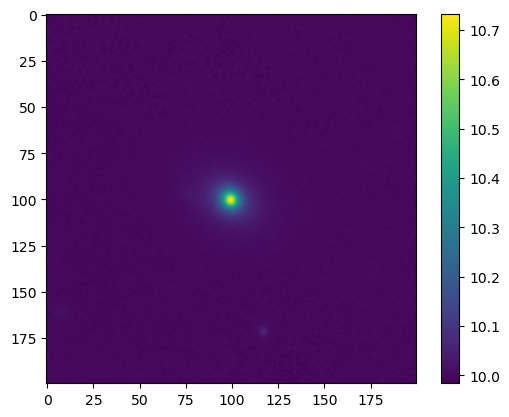

In [92]:
plt.imshow(dat)
plt.colorbar()

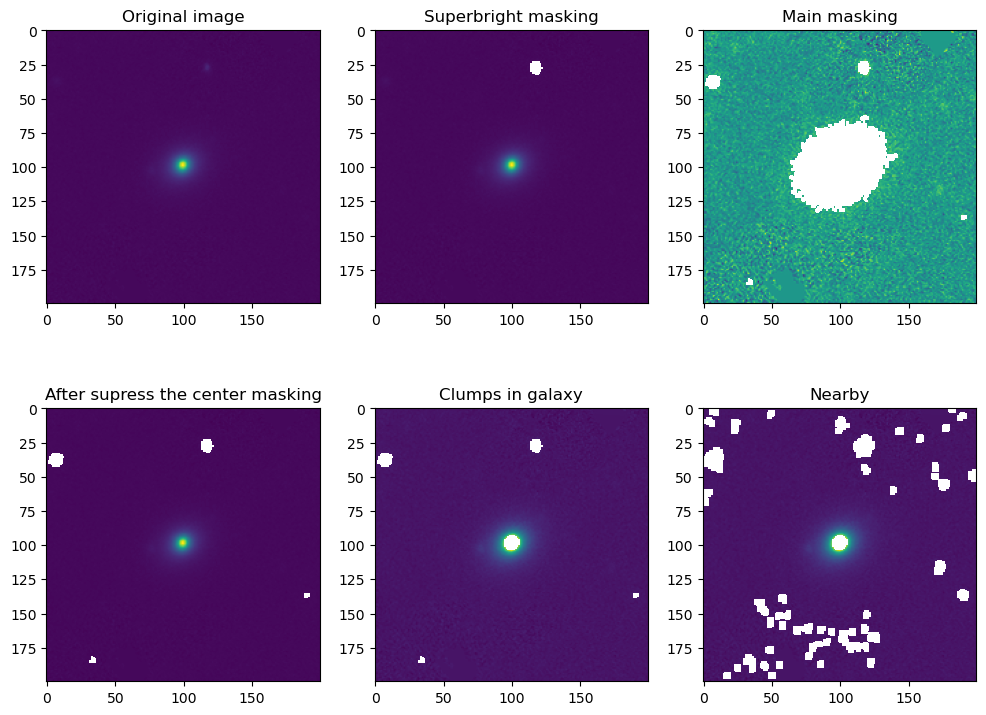

In [93]:
## Bright Sersic gal
# i=11
# dir_work=DI.dir_work_list[i]
# fn_image=dir_work+'image_lg.fits'
#prev=fits.getdata(dir_work+'ext_maskbits_l1.fits')

Mask1=dhmask2.Masking2(fn_image=fn_image, ## Image file
                       #mask_prev=prev,
                       thresh=1.5, minarea=5,  ## Threshold & Minimum pixel numbers
                       suppress_center=5,  ## If you don't want mask the center. Size [pixel]
                       centermasking_is_touch=True,  ## Size: object center or boundary? True -> Boundary
                       ### Additional Masking parameters
                       superbright=True, superbright_thresh=0.01,  ## Mask pixel above the thresh [pixel value]
                       superbright_suppress_center=10,
                       ## Clumps inside the target
                       cig_thresh=100, cig_maxarea=800, cig_minarea=2,
                       nb=True, nb_thresh=1, ## Nearby harsh masking (blur)
                       silent=True,
              )

fig=plt.figure(figsize=(12,9))
gs=gridspec.GridSpec(2,3)
ax0=plt.subplot(gs[0])
plt.title("Original image")
plt.imshow(Mask1.usingimg[::-1])
ax0=plt.subplot(gs[1])
plt.title("Superbright masking")
newdat=np.ma.masked_array(Mask1.usingimg, Mask1.mask_superbright)
plt.imshow(newdat[::-1])
ax0=plt.subplot(gs[2])
plt.title("Main masking")
newdat=np.ma.masked_array(Mask1.usingimg, Mask1.mask_main)
plt.imshow(newdat[::-1])
ax0=plt.subplot(gs[3])
plt.title("After supress the center masking")
newdat=np.ma.masked_array(Mask1.usingimg, Mask1.mask_main_sup)
plt.imshow(newdat[::-1])
ax0=plt.subplot(gs[4])
plt.title("Clumps in galaxy")
newdat=np.ma.masked_array(Mask1.usingimg, Mask1.mask_main_supcig)
plt.imshow(newdat[::-1])
ax0=plt.subplot(gs[5])
plt.title("Nearby")
newdat=np.ma.masked_array(Mask1.usingimg, Mask1.mask_nb_supcig)
plt.imshow(newdat[::-1])

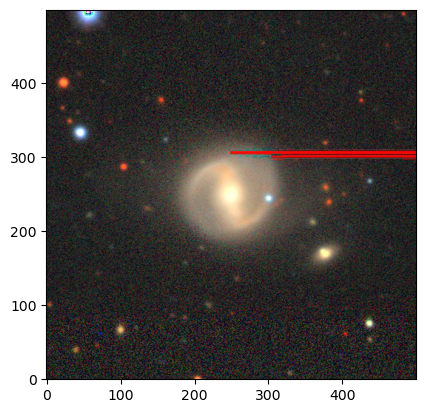

In [37]:
i=0
image_filename = 'https://www.legacysurvey.org/viewer/jpeg-cutout?ra='+str(DI.coord_array[i][0])+'&dec='+str(DI.coord_array[i][1])+'&size=500&layer=ls-dr9'
#print(image_filename)
plt.imshow(skimage.io.imread( image_filename )[::-1], origin='lower')
plt.show()

## Multicore - Run

In [96]:
def multicore_masking2(DirInfo, Ncore=2, show_progress=1000, band='g',
                      centermasking_is_touch=False, centermasking_is_touch_nb=True,
                      silent=True, fna_prev_masking=None, is_overwrite=True, suffix='', debug=False):
    global sub_masking
    def sub_masking(i):
        dir_work=DirInfo.dir_work_list[i]

        fn_image=dir_work+'image_l'+band+'.fits'
        fn_masking=dir_work+'masking_'+band+suffix+'.fits'
        fn_masking_d=dir_work+'masking_'+band+suffix+'_d.fits'   #double
        fn_cig_objects=dir_work+'maskobj_'+band+suffix+'.npy'

        if(show_progress>0):
            if(i%show_progress==0): print(i, "/", len(DirInfo.dir_work_list), "| Time : ", time.time()-start)


        try:
            # First masking

            Mask1=dhmask2.Masking2(fn_image=fn_image, ## Image file
                                   #mask_prev=prev,
                                   thresh=1.5, minarea=5,  ## Threshold & Minimum pixel numbers
                                   suppress_center=5,  ## If you don't want mask the center. Size [pixel]
                                   centermasking_is_touch=True,  ## Size: object center or boundary? True -> Boundary
                                   ### Additional Masking parameters
                                   superbright=True, superbright_thresh=0.01,  ## Mask pixel above the thresh [pixel value]
                                   superbright_suppress_center=10,
                                   ## Clumps inside the target
                                   cig_thresh=100, cig_maxarea=800, cig_minarea=2,
                                   nb=True, nb_thresh=1, ## Nearby harsh masking (blur)
                                   silent=True,
                          )

            dhmask2.save_mask(fn_masking, Mask1.mask_main_sup)
            dhmask2.save_mask(fn_masking_d, Mask1.mask_main_supcig)
            np.save(fn_cig_objects, Mask1.obj_cig)


        except:
            print("Error >> ", i)

    start=time.time()
    if(Ncore>1):
        pool = Pool(processes=int(Ncore))
        pool.map(sub_masking, np.arange(len(DirInfo.dir_work_list)))
        pool.close()
        pool.join()
        print("Done! | Time : ", time.time()-start)
    else:
        if(debug==True):
            return sub_masking(0)
        else:
            for i in range (len(DirInfo.dir_work_list)):
                sub_masking(i)
            print("Done! | Time : ", time.time()-start)

In [97]:
multicore_masking2(DIgood, Ncore=Ncore, fna_prev_masking=None, suffix='', band='g',
                   debug=False, show_progress=1,
                          centermasking_is_touch=True, is_overwrite=True)

10234576        ////// //     8  8888888       | Time : | Time :  | Time : | Time : | Time : | Time : | Time :   | Time :     0.11331558227539062  0.11337208747863770.113460063934326170.113805770874023440.113546371459960940.1137235164642334
0.113625049591064450.11388993263244629






Done! | Time :  0.2105863094329834


In [98]:
multicore_masking2(DIgood, Ncore=Ncore, fna_prev_masking=None, suffix='', band='r',
                   debug=False, show_progress=1,
                          centermasking_is_touch=True, is_overwrite=True)

32410567        /////// /       8888888 8       | Time : | Time : | Time : | Time : | Time : | Time : | Time :  | Time :       0.120826482772827150.12090373039245605 0.120709180831909180.121004819869995120.121219635009765620.121173620223999020.12108969688415527

0.1207742691040039





Done! | Time :  0.2285916805267334


## G & R Combine

In [99]:
import DH_multicore as mulcore

In [100]:
def multicore_masking_combine(DirInfo, masknamelist=['.fits', '_d.fits',],
                              band1='g', band2='r', newband='c', suffix='e1',
                          Ncore=16, show_progress=1000, use_try=False, show_multicore=True):
    global sub_masking_combine
    print("Start Multicore run")

    def sub_masking_combine(i):
        dir_work=DirInfo.dir_work_list[i]
        for maskname in masknamelist:
            try:
                mask1=fits.getdata(dir_work+'masking_'+band1+suffix+maskname)
                mask2=fits.getdata(dir_work+'masking_'+band2+suffix+maskname)
          
                fn_newmask=dir_work+'masking_'+newband+suffix+maskname
                newmask=dhmask.masking_sum(mask1, mask2)

                maskfile = fits.PrimaryHDU()
                maskfile.data = newmask.astype('int16')
                maskfile.writeto(fn_newmask, overwrite = True)
            except: print("Error >> ", i)

    return mulcore.multicore_run(sub_masking_combine, len(DirInfo.dir_work_list), Ncore=Ncore,
                          use_try=use_try, show_progress=show_progress, debug=show_multicore)

In [101]:
task=multicore_masking_combine(DIgood, suffix='', Ncore=Ncore)

Start Multicore run
Multicore run for sub_masking_combine with Ncore 16
show_progress :  1000
Using Try :  False


100%|███████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 434.37it/s]

Done! | Time :  0.15387868881225586


# Sigma extraction (Skip)

## g-band

In [ ]:
dhfc.multicore_remove(DI.dir_work_list, Ncore=4, fna='sigma_g.fits', show_progress=1000,)

In [ ]:
MC2fitSet_sigma_g=dhmc2fit.Setting(plate_scale=plate_scale, 
                                   image_size=image_size,
                                   zeromag=0,
                                   est_sky=0,
                           fni_sigma=None,  ## We do not have sigma
                           is_run_galfit_dir_work=True, ## Run galfit in each folder (to extract sigma)
                           extract_sigma=True, ## Extract Galfit internal sigma
                           output_block=False, ## Do not run Galfit itself (reduce the time)
                                )
MC2fitSet_sigma_g

In [ ]:
est_params_array=np.array([[np.nan, np.nan, 20, 30, 1, np.nan, np.nan]], dtype='object')
RunlistSig=dhmc2fit.Runlist(MC2fitSet_sigma_g, namelist='test20', complist=['sersic2'],
                            est_params_array=est_params_array,
                            group_id=0, ## Fitting group
                            size_conv=101, ## Convolution box size 
                            lim_pos=np.array([[200, 300]]), ## position constraint (from - to)
                            lim_n=[[0, 2]],  ## Sersic index constraint (from - to)
                            lim_reff=np.nan, ## effective radii constraint (use None here) 
                            lim_ar=[[0.2, 1.1]], ## Axis ratio constraint (from - to)
                           )

RunlistSig.show_runlist() ## Show the summary

## r-band

In [ ]:
## Setting
MC2fitSet_sigma_r=dhmc2fit.Setting(plate_scale=0.2, 
                                   zeromag=0,
                           fni_image='image_r.fits',
                           band='r',
                           fni_sigma=None,  ## We do not have sigma
                           is_run_galfit_dir_work=True, ## Run galfit in each folder (to extract sigma)
                           extract_sigma=True, ## Extract Galfit internal sigma
                           output_block=False, ## Do not run Galfit itself (reduce the time)
                          )

## Extract sigma
Run=dhmc2fit.MC2fitRun_Mulcore(MC2fitSet_sigma_r, RunlistSig, DI)

## Change the name
dhfc.multicore_rename(DI.dir_work_list,
                      fna='sigma.fits', ## Name
                      prev_pattern='.fits', ## From
                      new_pattern='_r.fits' ## To
                     )